In [1]:
import sys 

In [ ]:
cd '/srv/share3/hagrawal9/project/habitat/habitat-api/'

In [3]:
import gzip
import json
import os
import sys
from typing import Any, Dict, List, Optional, Type

import attr
import cv2
import git
import magnum as mn
import numpy as np

# %matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image


import habitat
import habitat_sim
from habitat.config import Config
from habitat.core.registry import registry
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import observations_to_image

In [4]:
from habitat.datasets.rearrangement.rearrangement_dataset import RearrangementDatasetV0
from habitat.tasks.rearrangement.rearrangement_task import RearrangementEpisode

In [5]:
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
# %cd $dir_path
data_path = os.path.join(dir_path, "data")
output_directory = "data/tutorials/output/"  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)

In [6]:
config = habitat.get_config("configs/tasks/rearrangement_gibson.yaml")

In [7]:
config.defrost()
config.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'TOP_DOWN_MAP']
config.freeze()

In [8]:
def make_video_cv2(
    observations, cross_hair=None, prefix="", open_vid=True, fps=60
):
    sensor_keys = list(observations[0])
    videodims = observations[0][sensor_keys[0]].shape
    videodims = (videodims[1], videodims[0])  # flip to w,h order
    print(videodims)
    video_file = output_path + prefix + ".mp4"
    print("Encoding the video: %s " % video_file)
    writer = vut.get_fast_video_writer(video_file, fps=fps)
    for ob in observations:
        # If in RGB/RGBA format, remove the alpha channel
        rgb_im_1st_person = cv2.cvtColor(ob["rgb"], cv2.COLOR_RGBA2RGB)
        if cross_hair is not None:
            rgb_im_1st_person[
                cross_hair[0] - 2 : cross_hair[0] + 2,
                cross_hair[1] - 2 : cross_hair[1] + 2,
            ] = [255, 0, 0]

        if rgb_im_1st_person.shape[:2] != videodims:
            rgb_im_1st_person = cv2.resize(
                rgb_im_1st_person, videodims, interpolation=cv2.INTER_AREA
            )
        # write the 1st person observation to video
        writer.append_data(rgb_im_1st_person)
    writer.close()

    if open_vid:
        print("Displaying video")
        vut.display_video(video_file)


In [9]:
def print_info(obs, metrics):
    print(
        "Gripped Object: {}, Distance To Object: {}, Distance To Goal: {}".format(
            obs["gripped_object_id"],
            metrics["agent_to_object_distance"],
            metrics["object_to_goal_distance"],
        )
    )

In [10]:
if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--no-display", dest="display", action="store_false")
    parser.add_argument(
        "--no-make-video", dest="make_video", action="store_false"
    )
    parser.set_defaults(show_video=True, make_video=True)
    args, _ = parser.parse_known_args()
    show_video = args.display
    display = args.display
    make_video = args.make_video
else:
    show_video = False
    make_video = False
    display = False

In [11]:
try:
    env.close()
except:
    pass
env = habitat.Env(config)

2020-10-01 03:44:17,434 Initializing dataset RearrangementDataset-v0
2020-10-01 03:44:17,439 initializing sim RearrangementSim-v0
I1001 03:44:21.868749 42181 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Barboursville.navmesh
I1001 03:44:21.870619 42181 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.
2020-10-01 03:44:21,968 Initializing task RearrangementTask-v0


In [12]:
obs = env.reset()
obs_list = []
# Get closer to the object

obs = env.step(1)
# obs_list.append(obs)
# metrics = env.get_metrics()
# print_info(obs, metrics)

# Grab the object
# obs = env.step(2)
obs_list.append(obs)
metrics = env.get_metrics()

rotating agent!


In [13]:
make_video_cv2(
    obs_list,
    [240, 320],
    "hard-coded-agent",
    fps=5.0, 
    open_vid=show_video,
)

(640, 480)
Encoding the video: /coc/pskynet3/hagrawal9/project/habitat/habitat-api/data/tutorials/output/hard-coded-agent.mp4 
Displaying video


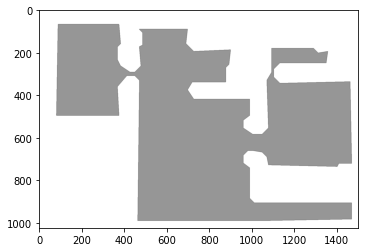

In [23]:
navmesh_settings = habitat_sim.NavMeshSettings()
navmesh_settings.set_defaults()
navmesh_settings.agent_radius = 0.2
navmesh_settings.agent_height = 0.88
navmesh_settings.agent_max_climb = 0.1
env._sim.recompute_navmesh(env._sim.pathfinder, env._sim.navmesh_settings, False)

top_down_map = maps.get_topdown_map(
    env._sim.pathfinder,
    env._sim.get_agent(0).state.position[1],
    1024
)

top_down_map = maps.colorize_topdown_map(top_down_map)
agent_position = env._sim.get_agent_state().position
a_x, a_y = maps.to_grid(
    agent_position[2],
    agent_position[0],
    top_down_map.shape[0:2],
    sim=env._sim,
)

episode = env.current_episode
object_positions = [obj.position for obj in episode.objects]
goal_positions = [obj.position for obj in episode.goals]

grid_object_positions = []
grid_goal_positions = []

for i, obj_pos in enumerate(object_positions):
    tdm_pos = maps.to_grid(
        obj_pos[2],
        obj_pos[0],
        top_down_map.shape[0:2],
        sim=env._sim,
    )
    grid_object_positions.append(tdm_pos)

# draw the objectgoal positions.
for i, goal_pos in enumerate(goal_positions):
    tdm_pos = maps.to_grid(
        goal_pos[2],
        goal_pos[0],
        top_down_map.shape[0:2],
        sim=env._sim,
    )

    grid_goal_positions.append(tdm_pos)
    
# top_down_map = maps.draw_agent(
#     image=top_down_map,
#     agent_center_coord=[a_x, a_y],
#     agent_rotation=metrics["top_down_map"]["agent_angle"],
#     agent_radius_px=min(top_down_map.shape[0:2]) / 32,
# )

# top_down_map = maps.draw_object_info(top_down_map, grid_object_positions, grid_goal_positions)

plt.imshow(top_down_map)

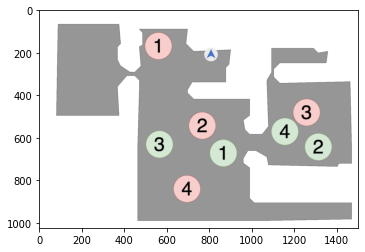

In [15]:
top_down_map = maps.draw_object_info(top_down_map, grid_object_positions, grid_goal_positions)
plt.imshow(top_down_map)

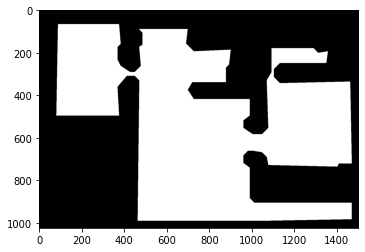

In [75]:
tdmap = top_down_map[:, :, 0]
tdmap[tdmap < 200] = 0
tdmap = np.invert(tdmap)
plt.imshow(tdmap, cmap="gray")

In [76]:
import cv2
import numpy as np
import skfmm
from numpy import ma

In [104]:
def compute_distance_using_fmm(traversible_map, anchor_point):
    traversible_ma = ma.masked_values(traversible_map * 1, 0)
    traversible_ma[anchor_point[0], anchor_point[1]] = 0
    dmap = skfmm.distance(traversible_ma, dx=1)
    dmap_mask = np.invert(np.isnan(ma.filled(dmap, np.nan)))
    dmap = ma.filled(dmap, np.inf)
    return dmap

In [105]:
def find_shortest_path(dmap, point):
    return dmap[point[0], point[1]]

def find_all_pair_shortest_path(tdmap, agent_pos, object_positions, goal_positions):
    shortest_path_lengths = []
    for p1 in [agent_pos] + object_positions + goal_positions:
        dmap = compute_distance_using_fmm(tdmap, p1)
        path_lengths = []
        for p2 in [agent_pos] + object_positions + goal_positions :
            path_lengths.append(find_shortest_path(dmap, p2))
        shortest_path_lengths.append(path_lengths)
    return shortest_path_lengths

In [106]:
tdmap[tdmap > 1] = 1
dmat = find_all_pair_shortest_path(tdmap, [0, 0], grid_object_positions, grid_goal_positions)

In [107]:
dmat

[[0.0, inf, inf, inf, inf, inf, inf, inf, inf],
 [inf,
  0.0,
  447.1961867182115,
  302.9102914799196,
  306.3485898174832,
  588.4638052562881,
  162.83004109517327,
  435.4015313883409,
  239.93508573081044],
 [inf,
  447.1572391999122,
  0.0,
  746.11436138278,
  172.9436718577299,
  936.3023750766032,
  554.252208466841,
  171.2885441545613,
  669.5249940216996],
 [inf,
  302.9102914799196,
  746.11436138278,
  0.0,
  592.1813598878548,
  462.0398619106146,
  219.63930765730913,
  717.0467470300175,
  245.82793860507113],
 [inf,
  306.34858964083145,
  172.9436718577299,
  592.1826125596001,
  0.0,
  774.356458992537,
  392.2967611096616,
  136.24814571286046,
  533.6849710705019],
 [inf,
  588.468224441596,
  936.4718378017355,
  462.0398619106146,
  774.3772905954186,
  0.0,
  427.2026835123324,
  899.3819683431259,
  684.4073643389968],
 [inf,
  162.83004109517327,
  554.2244189267325,
  219.63930765730913,
  392.2930358089985,
  427.202665236825,
  0.0,
  517.2977135542444,
  